# Generative process

## Definitions

We can generate participants' biomarker data according to EBM (Event-Based Model). 

$S \sim {\rm UniformPermutation}(\cdot)$

$S$ follows a distribution of uniform permutation. That means the ordering of biomarkers is random. 

$k_j \sim {\rm DiscreteUniform}(N)$

$k_j$ follows a discrete uniform distribution, which means a participant is equally likely to fall in a progression stage (e.g., from $0$ to $4$, where $0$ indicate this participant is healthy.)

$$X_{S(n)j} | S, k_j  \sim I(z_j == 1) \left[ I(S(n) \leq k_j ) p(X_{S(n)j} \mid \theta_{S(n)} ) +I(S(n) \gt k_j) p(X_{S(n)j} \mid \phi_{S(n)}) \right] +  \left(1-I(z_j==1) \right) p(X_{S(n)j} \mid \phi_{S(n)})$$

Note that $\sim$ in statistics indicates that this variable follows a certain distribution. Here, it means that the biomarker values is drawn from that distribution. 

## Parameters

$z_j$: $1$ if the participant is diseased; otherwise $0$.

$I(True) = 1$, $I(False) = 0$

$S$ denotes the ordering of a sequence of biomarkers. 

$N$: number of observed biomarkers.

$n$: a specific biomarker; e.g., biomarker $b$.

$J$: number of participants. 

$j$ denotes a participant. 

$X$ is observed values of biomarkers; it is a matrix of dimension of $N \times J$ or $J \times N$.

$k$: a scalar whose value is the participant's stage of the disease

$K$: number of disease stages

$S(n)$ means the disease stage that a specific biomarker $n$ indicates. 

$k_j$: disease stage that a participant is at. 

$X_{nj}$ means the observed value of the biomarker $n$ in participant $j$. 

$\theta_n$ is the parameters for the probability density function (PDF) of observed value of biomarker $n$ when this biomarker has been affected by the disease. Let's assume this distribution is a Gaussian distribution.

$\phi_n$ is the parameters for the probability density function (PDF) of observed value of biomarker $n$ when this biomarker has NOT been affected by the disease. 

## Simulation

**We are going to generate biomarker values for each participant by randomly drawing from distributions defined by $\theta$ or $\phi$. We will base our generation on Chen's paper (Figure 1).**

![](./img/chen_fig1.png)

In [106]:
import numpy as np
import scipy.stats as stats
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt

In [107]:
# S_ordering = [5, 6, 3, 4, 1, 7, 8, 2, 9, 10]

In [108]:
def get_zscore(arr):
    mu = np.mean(arr)
    std = np.std(arr)
    return (arr - mu)/std

def min_max_scale(arr):
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    scaled_arr = (arr - arr_min) / (arr_max - arr_min)
    return scaled_arr

In [109]:
biomarker_names = np.array([
    'MMSE', 'ADAS', 'AB', 'P-Tau', 'HIP-FCI', 
    'HIP-GMI', 'AVLT-Sum', 'PCC-FCI', 'FUS-GMI', 'FUS-FCI'])
biomarker_index_name_dict = dict(zip(range(len(biomarker_names)), biomarker_names))
S_ordering = np.array([
    'HIP-FCI', 'PCC-FCI', 'AB', 'P-Tau', 'MMSE', 'ADAS', 
    'HIP-GMI', 'AVLT-Sum', 'FUS-GMI', 'FUS-FCI'
    ])
# biomarker_names
# cyan, normal
theta_means = [28, -6, 250, -25, 5, 0.4, 40, 12, 0.6, -10]
# black, abnormal
phi_means = [22, -20, 150, -50, -5, 0.3, 20, 5, 0.5, -20]
# cyan, normal
theta_std_times_three = [2, 4, 150, 50, 5, 0.7, 45, 12, 0.2, 10]
theta_stds = [std_dev/3 for std_dev in theta_std_times_three]
# black, abnormal
phi_std_times_three = [8, 12, 50, 100, 20, 1, 20, 10, 0.2, 18]
phi_stds = [std_dev/3 for std_dev in phi_std_times_three]

# """apply z score transformation"""
# theta_means = get_zscore(theta_means)
# phi_mean = get_zscore(phi_means)
# theta_stds = get_zscore(theta_stds)
# phi_stds = get_zscore(phi_stds)

# # Apply min-max scaling
# theta_means_scaled = min_max_scale(theta_means)
# phi_means_scaled = min_max_scale(phi_means)
# theta_stds_scaled = min_max_scale(theta_stds)
# phi_stds_scaled = min_max_scale(phi_stds)

In [110]:
## We only use five biomarkers for simplicity reasons
biomarker_names = biomarker_names[0:5]
S_ordering = np.array(['HIP-FCI', 'AB', 'P-Tau', 'MMSE', 'ADAS'])
# the real order should be this: [4, 5, 2, 3, 1]
theta_means = theta_means[0:5]
theta_stds = theta_stds[0:5]
phi_means = phi_means[0:5]
phi_stds = phi_stds[0:5]

In [111]:
biomarker_index_name_dict

{0: 'MMSE',
 1: 'ADAS',
 2: 'AB',
 3: 'P-Tau',
 4: 'HIP-FCI',
 5: 'HIP-GMI',
 6: 'AVLT-Sum',
 7: 'PCC-FCI',
 8: 'FUS-GMI',
 9: 'FUS-FCI'}

In [112]:
# theta_means = [1, 3, 5, 6, 8, 0, 4, 2, 7, 9]
# theta_stds = [0.3, 0.5, 0.2, 1.3, 3.3, 2.2, 0.8, 0.9, 0.7, 0.6]
# phi_means = [32, 31, 34, 36, 38, 39, 30, 33, 35, 37]
# phi_stds = [6.3, 7.4, 9.4, 4.9, 2.5, 5.9, 6.4, 7.7, 8.0, 3.0]

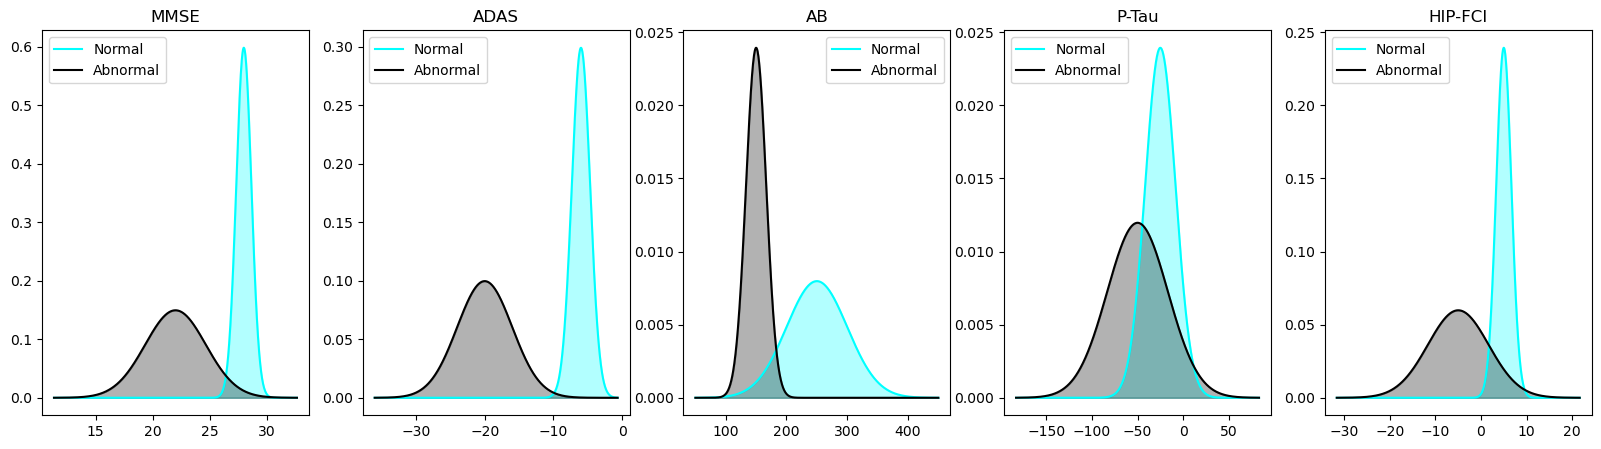

In [113]:
def plot_distribution_pair(ax, mu1, sigma1, mu2, sigma2, title):
    xmin = min(mu1 - 4*sigma1, mu2-4*sigma2)
    xmax = max(mu1 + 4*sigma1, mu2 + 4*sigma2)
    x = np.linspace(xmin, xmax, 1000)
    y1 = stats.norm.pdf(x, loc = mu1, scale = sigma1)
    y2 = stats.norm.pdf(x, loc = mu2, scale = sigma2)
    ax.plot(x, y1, label = "Normal", color = "cyan")
    ax.plot(x, y2, label = "Abnormal", color = "black")
    ax.fill_between(x, y1, alpha = 0.3, color = "cyan")
    ax.fill_between(x, y2, alpha = 0.3, color = "black")
    ax.set_title(title)
    ax.legend()

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, biomarker_name in enumerate(biomarker_names):
    ax = axes.flatten()[i] 
    mu1 = theta_means[i]
    mu2 = phi_means[i]
    sigma1 = theta_stds[i]
    sigma2 = phi_stds[i]
    plot_distribution_pair(
        ax, mu1, sigma1, mu2, sigma2, title = biomarker_name)

In [114]:
for n, biomarker in enumerate(biomarker_names):
    print(n, biomarker)

0 MMSE
1 ADAS
2 AB
3 P-Tau
4 HIP-FCI


In [115]:
def simulate_ebm(
        biomarker_names, S_ordering, J, theta_means, theta_std_dev, phi_means, phi_std_dev):
    """
    Simulate an Event-Based Model (EBM) for disease progression.
    
    Args:
    biomarker_names: Biomarker names
    S_ordering: Biomarker names ordered according to the order in which each of them get affected 
    by the disease
    J (int): Number of participants.
    
    Returns:
    tuple: A tuple containing:
        - kjs (numpy.ndarray): The disease stages for participant.
        - X (numpy.ndarray): The biomarker matrix with participant data.
          - Each cell in X is tuple containing participantId, biomarker name, biomarker value, 
            disease stage of this participant, disease stage current biomarker indicates
            and healthy status
    """
    # N (int): Number of biomarkers.
    N = len(biomarker_names)
    
    # Generate a random stage for each participant
    # The stage should be between 0 and N, inclusive
    # stage 0 indicate the participant is healthy (normal)
    kjs = np.random.randint(0, N+1, size=J)
    
    # Initiate biomarker measurement matrix (J participants x N biomarkers), 
    # with entries as None
    X = np.full((J, N), None, dtype=object)
    
    # biomarker : normal distribution
    theta_dist = {biomarker: stats.norm(
        theta_means[n], theta_std_dev[n]) for n, biomarker in enumerate(biomarker_names)}
    phi_dist = {biomarker: stats.norm(
        phi_means[n], phi_std_dev[n]) for n, biomarker in enumerate(biomarker_names)}

    # Iterate through participants
    for j in range(J):
        # Iterate through biomarkers
        for n, biomarker in enumerate(biomarker_names):
            # Disease stage of the current participant
            k_j = kjs[j]
            # Disease stage indicated by the current biomarker
            # Note that biomarkers always indicate that the participant is diseased
            # Thus, S_n >= 1
            S_n = np.where(S_ordering == biomarker)[0][0] + 1
            
            # Assign biomarker values based on the participant's disease stage 
            if k_j >= 1:
                if k_j >= S_n:
                    X[j, n] = (j, biomarker, theta_dist[biomarker].rvs(), k_j, S_n, 'affected') 
                else:
                    X[j, n] = (j, biomarker, phi_dist[biomarker].rvs(), k_j, S_n, 'not_affected')  
            # if the participant is healthy
            else:
                X[j, n] = (j, biomarker, phi_dist[biomarker].rvs(), k_j, S_n, 'not_affected')        
    return kjs, X

In [116]:
J = 100
kjs, X = simulate_ebm(biomarker_names, S_ordering, J, theta_means, theta_stds, phi_means, phi_stds)

In [117]:
theta_means, theta_stds, phi_means, phi_stds

([28, -6, 250, -25, 5],
 [0.6666666666666666,
  1.3333333333333333,
  50.0,
  16.666666666666668,
  1.6666666666666667],
 [22, -20, 150, -50, -5],
 [2.6666666666666665,
  4.0,
  16.666666666666668,
  33.333333333333336,
  6.666666666666667])

In [118]:
df_means_stds = pd.DataFrame([theta_means, theta_stds, phi_means, phi_stds]).transpose()
df_means_stds.columns = ['theta_mean', 'theta_std', 'phi_mean', 'phi_std']
df_means_stds = df_means_stds.rename_axis("biomarker", axis=0).reset_index()
df_means_stds['biomarker'] = df_means_stds.apply(lambda row: biomarker_index_name_dict[row.biomarker], axis = 1)
df_means_stds

,biomarker,theta_mean,theta_std,phi_mean,phi_std
0,MMSE,28.0,0.666667,22.0,2.666667
1,ADAS,-6.0,1.333333,-20.0,4.000000
2,AB,250.0,50.000000,150.0,16.666667
3,P-Tau,-25.0,16.666667,-50.0,33.333333
4,HIP-FCI,5.0,1.666667,-5.0,6.666667


In [119]:
df_means_stds.to_csv('data/means_stds.csv', index=False)

In [120]:
X[10]

array([(10, 'MMSE', 22.100610313252385, 1, 4, 'not_affected'),
       (10, 'ADAS', -16.201649123003275, 1, 5, 'not_affected'),
       (10, 'AB', 134.9832600433161, 1, 2, 'not_affected'),
       (10, 'P-Tau', -61.00409619067233, 1, 3, 'not_affected'),
       (10, 'HIP-FCI', 5.9809828883729335, 1, 1, 'affected')],
      dtype=object)

Please note that "not_affected" and "affected" are refering to a specific biomarker, rather than this participant's healthy status. 

In [121]:
df = pd.DataFrame(X, columns=biomarker_names)
df
# make this dataframe wide to long 
df_long = df.melt(var_name = "Biomarker", value_name="Value")
df_long
values_df = df_long['Value'].apply(pd.Series)
values_df.columns = ['participant', "biomarker", 'measurement', 'k_j', 'S_n', 'affected_or_not']
values_df

,participant,biomarker,measurement,k_j,S_n,affected_or_not
0,0,MMSE,27.791506,4,4,affected
1,1,MMSE,28.575872,5,4,affected
2,2,MMSE,28.246826,4,4,affected
3,3,MMSE,28.333701,5,4,affected
4,4,MMSE,23.204995,1,4,not_affected
...,...,...,...,...,...,...
495,95,HIP-FCI,5.196529,3,1,affected
496,96,HIP-FCI,5.417069,3,1,affected
497,97,HIP-FCI,-15.881792,0,1,not_affected
498,98,HIP-FCI,6.474694,3,1,affected


## Visualizing simulated results

With the above data structure, we can visualize the following data:

- Distribution of all biomarker values by biomarker
- Distribution of all biomarker values when the participant is at a certain disease stage
- Comparing a certain biomarker data 
- A certain participant's data

### Distribution of all biomarker values by biomarker

In [122]:
df = pd.DataFrame(X, columns=biomarker_names)
# make this dataframe wide to long 
df_long = df.melt(var_name = "Biomarker", value_name="Value")
values_df = df_long['Value'].apply(pd.Series)
values_df.columns = ['participant', "biomarker", 'measurement', 'k_j', 'S_n', 'affected_or_not']
df = values_df

alt.Chart(df).transform_density(
    'measurement',
    as_=['measurement', 'Density'],
    groupby=['biomarker']
).mark_area().encode(
    x="measurement:Q",
    y="Density:Q",
    facet = alt.Facet(
        "biomarker:N",
        columns = 5
    ),
    color=alt.Color(
        'biomarker:N'
    )
).properties(
    width= 140,
    height = 200,
).properties(
    title='Biomarker data for all participants across all stages'
)

alt.Chart(...)

In [123]:
df.to_csv("data/participant_data.csv", index=False)
df.head()

,participant,biomarker,measurement,k_j,S_n,affected_or_not
0,0,MMSE,27.791506,4,4,affected
1,1,MMSE,28.575872,5,4,affected
2,2,MMSE,28.246826,4,4,affected
3,3,MMSE,28.333701,5,4,affected
4,4,MMSE,23.204995,1,4,not_affected


In [124]:
# df[df.k_j == 0]

### Distribution of all biomarker values when the participant is at a certain disease stage

In [125]:
# biomarker data when the participant is at stage 6
df_kj_3 = df[df.k_j == 3]
df_kj_3

alt.Chart(df_kj_3).transform_density(
    'measurement',
    as_=['measurement', 'Density'],
    groupby=['biomarker']
).mark_area().encode(
    x="measurement:Q",
    y="Density:Q",
    facet = alt.Facet(
        "biomarker:N",
        columns = 5
    ),
    color=alt.Color(
        'biomarker:N'
    )
).properties(
    width= 140,
    height = 200,
).properties(
    title='Biomarker data when the participant is at stage six'
)

alt.Chart(...)

### Comparing a certain biomarker data 

In [126]:
# select only biomarker 2 
bio_2_data = df[df.biomarker=='MMSE'].drop(['k_j', 'S_n', 'biomarker'], axis = 1)
# biomarker2 data, comparing from diseased and healthy groups
alt.Chart(bio_2_data).transform_density(
    'measurement',
    as_=['measurement', 'Density'],
    groupby=['affected_or_not']
).mark_area().encode(
    x="measurement:Q",
    y="Density:Q",
    facet = alt.Facet(
        "affected_or_not:N",
    ),
    color=alt.Color(
        'affected_or_not:N'
    )
).properties(
    width= 240,
    height = 200,
).properties(
    title='MMSE data, compring healthy group and diseased group'
)

alt.Chart(...)

### A certain participant's data

In [127]:
# participant 10
participant10_data = df[df.participant == 10]
alt.Chart(participant10_data).mark_bar().encode(
    x='biomarker',
    y='measurement',
    color=alt.Color(
        'affected_or_not:N'
    ),
    tooltip=['biomarker', 'affected_or_not', 'measurement']
).interactive().properties(
    title=f'Biomarker data for participant 10 (k_j = {participant10_data.k_j.to_list()[0]})'
)

alt.Chart(...)